# Deep learning

# 1. Theano

Basic Thenao concepts

In [86]:
#All imports here

import numpy as np
import theano
import theano.tensor as T
from theano import function
from theano import shared
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
import os
import time
from pandas import DataFrame, Series
import pandas as pd
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv
import matplotlib as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [87]:
x = T.scalar('x') #scalar variable
y = T.scalar('y') 

z = x**2
u = x + y

print type(u)
print type(z)

<class 'theano.tensor.var.TensorVariable'>
<class 'theano.tensor.var.TensorVariable'>


In [92]:
#Tensor manipulation
v = theano.function([x,y],u)
print 'v= ',v(2,3)

w = theano.function([x],z)
print 'w= ',w(3)

v=  5.0
w=  9.0


In [93]:
#Also this is possible
print 'u= ', u.eval({x:2,y:3})

print 'z= ', z.eval({x:3})

u=  5.0
z=  9.0


In [94]:
#Matrix manipulation

A = T.matrix('A')
B = T.vector('B')

C = T.dot(A,B)

dot_product = theano.function([A,B],C)

A1 = np.array([[1,2,3],[4,5,6]],dtype=theano.config.floatX)
B1 = np.array([1,2,3],dtype=theano.config.floatX)

print 'A1=',A1
print 'B1=',B1

print dot_product(A1,B1) 



A1= [[ 1.  2.  3.]
 [ 4.  5.  6.]]
B1= [ 1.  2.  3.]
[ 14.  32.]


In [95]:
#Shared variable
#Shared variable are like static variable, they gets shared to each function and gets globally updated.
shared_var = theano.shared(np.array([[1,2],[3,4]], dtype=theano.config.floatX))
print shared_var.type()
print shared_var.get_value()

<TensorType(float64, matrix)>
[[ 1.  2.]
 [ 3.  4.]]


In [96]:
shared_var.set_value(np.array([[3, 4], [2, 1]], dtype=theano.config.floatX))
print shared_var.get_value()

[[ 3.  4.]
 [ 2.  1.]]


In [98]:
shared_squared = shared_var**2
function_1 = theano.function([], shared_squared)
print 'shared_var=',shared_var.get_value()
print function_1()
#print 'shared_var=',shared_var.get_value()

shared_var= [[ 3.  4.]
 [ 2.  1.]]
[[  9.  16.]
 [  4.   1.]]


In [ ]:
#http://deeplearning.net/
#Alec Redford: https://www.youtube.com/watch?v=S75EdAcXHKk
#http://yann.lecun.com/exdb/mnist/
#Datasets available from Kaggle: 
#https://www.kaggle.com/c/digit-recognizer

In [10]:
def load_data(directory):
    ''' Loads the dataset
    '''

    #############
    # LOAD DATA #
    #############

    print '... loading data'

    # Load the dataset
    train_df = DataFrame.from_csv(directory + '/train.csv', index_col=False)
    test_df = DataFrame.from_csv(directory + '/test.csv', index_col=False)
    train_set = [train_df.values[0:35000, 1:] / 255., train_df.values[0:35000, 0]]
    valid_set = [train_df.values[35000:, 1:] / 255., train_df.values[35000:, 0]]
    test_set = test_df.values / 255.
    #train_set, valid_set format: tuple(input, target)
    #input is an numpy.ndarray of 2 dimensions (a matrix)
    #witch row's correspond to an example. target is a
    #numpy.ndarray of 1 dimensions (vector)) that have the same length as
    #the number of rows in the input. It should give the target
    #target to the example with the same index in the input.

    def shared_dataset(data_xy, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        data_x, data_y = data_xy
        shared_x = theano.shared(np.asarray(data_x,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        shared_y = theano.shared(np.asarray(data_y,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')

    test_set_x = theano.shared(np.asarray(test_set,
                                             dtype=theano.config.floatX),
                               borrow=True)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            test_set_x]
    return rval

In [41]:
#Visualization of the datasets

directory='/home/rbhat/workspace/S3Lab_Projects/Teaching'
train_df = DataFrame.from_csv(directory + '/train.csv', index_col=False)

label= 0


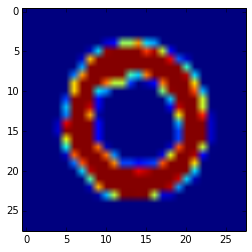

In [64]:
train_df.values[:,1:].shape
img1 = train_df.values[1,1:]
label1 = train_df.values[1,0]

print 'label=',label1
plt.pylab.imshow( np.reshape(img1,(28,28)) )

In [11]:
class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """

        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(value=np.zeros((n_in, n_out),
                                                 dtype=theano.config.floatX),
                                name='W', borrow=True)
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(value=np.zeros((n_out,),
                                                 dtype=theano.config.floatX),
                               name='b', borrow=True)

        # compute vector of class-membership probabilities in symbolic form
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # compute prediction as class whose probability is maximal in
        # symbolic form
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # parameters of the model
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|} \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
                \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y should have the same shape as self.y_pred',
                ('y', target.type, 'y_pred', self.y_pred.type))
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()
            
    def predict(self):
        return self.y_pred

In [12]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = np.asarray(rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)), dtype=theano.config.floatX)
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (lin_output if activation is None
                       else activation(lin_output))
        # parameters of the model
        self.params = [self.W, self.b]


class MLP(object):
    """Multi-Layer Perceptron Class

    A multilayer perceptron is a feedforward artificial neural network model
    that has one layer or more of hidden units and nonlinear activations.
    Intermediate layers usually have as activation function tanh or the
    sigmoid function (defined here by a ``HiddenLayer`` class)  while the
    top layer is a softamx layer (defined here by a ``LogisticRegression``
    class).
    """

    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hiddenLayer = HiddenLayer(rng=rng, input=input,
                                       n_in=n_in, n_out=n_hidden,
                                       activation=T.tanh)

        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out)

        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = abs(self.hiddenLayer.W).sum() \
                + abs(self.logRegressionLayer.W).sum()

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (self.hiddenLayer.W ** 2).sum() \
                    + (self.logRegressionLayer.W ** 2).sum()

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = self.logRegressionLayer.negative_log_likelihood
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        self.predict = self.logRegressionLayer.predict

# Neural Network training

In [54]:
learning_rate=0.025
L1_reg=0.00
L2_reg=0.0001
n_epochs=50
directory='/home/rbhat/workspace/S3Lab_Projects/Teaching'
batch_size=20
n_hidden=500

datasets = load_data(directory)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] / batch_size

######################
# BUILD ACTUAL MODEL #
######################
print '... building the model'

# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

rng = np.random.RandomState(1234)

# construct the MLP class
classifier = MLP(rng=rng, input=x, n_in=28 * 28,
                 n_hidden=n_hidden, n_out=10)

# the cost we minimize during training is the negative log likelihood of
# the model plus the regularization terms (L1 and L2); cost is expressed
# here symbolically
cost = classifier.negative_log_likelihood(y) \
        + L1_reg * classifier.L1 \
        + L2_reg * classifier.L2_sqr

# compiling a Theano function that computes the mistakes that are made
# by the model on a minibatch

validate_model = theano.function(inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: valid_set_x[index * batch_size:(index + 1) * batch_size],
                y: valid_set_y[index * batch_size:(index + 1) * batch_size]})

    # compute the gradient of cost with respect to theta (sotred in params)
    # the resulting gradients will be stored in a list gparams
gparams = []
for param in classifier.params:
    gparam = T.grad(cost, param)
    gparams.append(gparam)

# specify how to update the parameters of the model as a list of
# (variable, update expression) pairs
updates = []
# given two list the zip A = [a1, a2, a3, a4] and B = [b1, b2, b3, b4] of
# same length, zip generates a list C of same size, where each element
# is a pair formed from the two lists :
#    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
for param, gparam in zip(classifier.params, gparams):
    updates.append((param, param - learning_rate * gparam))

# compiling a Theano function `train_model` that returns the cost, but
# in the same time updates the parameter of the model based on the rules
# defined in `updates`
train_model = theano.function(inputs=[index], outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size:(index + 1) * batch_size],
                y: train_set_y[index * batch_size:(index + 1) * batch_size]})

###############
# TRAIN MODEL #
###############
print '... training'

# early-stopping parameters
patience = 10000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                        # found
improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

best_validation_loss = np.inf
best_iter = 0

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)
        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                     in xrange(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            print('epoch %i, validation error %f %%' %
                     (epoch, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                #improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss *  \
                        improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss

        if patience <= iter:
            done_looping = True
            break

... loading data
... building the model
... training
epoch 1, validation error 9.542857 %
epoch 2, validation error 8.500000 %
epoch 3, validation error 8.085714 %
epoch 4, validation error 7.428571 %
epoch 5, validation error 6.757143 %
epoch 6, validation error 6.242857 %
epoch 7, validation error 5.757143 %
epoch 8, validation error 5.442857 %
epoch 9, validation error 5.157143 %
epoch 10, validation error 4.914286 %
epoch 11, validation error 4.628571 %
epoch 12, validation error 4.485714 %
epoch 13, validation error 4.285714 %
epoch 14, validation error 4.171429 %
epoch 15, validation error 4.014286 %
epoch 16, validation error 3.971429 %
epoch 17, validation error 3.842857 %
epoch 18, validation error 3.685714 %
epoch 19, validation error 3.614286 %
epoch 20, validation error 3.600000 %
epoch 21, validation error 3.528571 %
epoch 22, validation error 3.385714 %
epoch 23, validation error 3.314286 %
epoch 24, validation error 3.214286 %
epoch 25, validation error 3.128571 %
epoch 

# Convolutional Neural Network

In [15]:
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height,filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows,#cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = np.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * np.prod(filter_shape[2:]) /
                   np.prod(poolsize))
        # initialize weights with random weights
        W_bound = np.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(np.asarray(
            rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
            dtype=theano.config.floatX),
                               borrow=True)

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = np.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv.conv2d(input=input, filters=self.W,
                filter_shape=filter_shape, image_shape=image_shape)

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(input=conv_out,
                                            ds=poolsize, ignore_border=True)

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1,n_filters,1,1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]
    
    def return_output():
        return self.output

In [16]:
learning_rate=0.1
directory='/home/rbhat/workspace/S3Lab_Projects/Teaching'
nkerns=[20, 50]
batch_size=500
""" Demonstrates lenet on MNIST dataset

:type learning_rate: float
:param learning_rate: learning rate used (factor for the stochastic
                        gradient)

:type n_epochs: int
:param n_epochs: maximal number of epochs to run the optimizer

:type dataset: string
:param dataset: path to the dataset used for training /testing (MNIST here)

:type nkerns: list of ints
:param nkerns: number of kernels on each layer
"""

rng = np.random.RandomState(23455)

datasets = load_data(directory)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches /= batch_size
n_valid_batches /= batch_size
n_test_batches /= batch_size

# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch
x = T.matrix('x')   # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

ishape = (28, 28)  # this is the size of MNIST images

######################
# BUILD ACTUAL MODEL #
######################
print '... building the model'

# Reshape matrix of rasterized images of shape (batch_size,28*28)
# to a 4D tensor, compatible with our LeNetConvPoolLayer
layer0_input = x.reshape((batch_size, 1, 28, 28))

# Construct the first convolutional pooling layer:
# filtering reduces the image size to (28-5+1,28-5+1)=(24,24)
# maxpooling reduces this further to (24/2,24/2) = (12,12)
# 4D output tensor is thus of shape (batch_size,nkerns[0],12,12)
layer0 = LeNetConvPoolLayer(rng, input=layer0_input,
            image_shape=(batch_size, 1, 28, 28),
            filter_shape=(nkerns[0], 1, 5, 5), poolsize=(2, 2))

# Construct the second convolutional pooling layer
# filtering reduces the image size to (12-5+1,12-5+1)=(8,8)
# maxpooling reduces this further to (8/2,8/2) = (4,4)
# 4D output tensor is thus of shape (nkerns[0],nkerns[1],4,4)
layer1 = LeNetConvPoolLayer(rng, input=layer0.output,
            image_shape=(batch_size, nkerns[0], 12, 12),
            filter_shape=(nkerns[1], nkerns[0], 5, 5), poolsize=(2, 2))

# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (batch_size,num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (20,32*4*4) = (20,512)
layer2_input = layer1.output.flatten(2)

# construct a fully-connected sigmoidal layer
layer2 = HiddenLayer(rng, input=layer2_input, n_in=nkerns[1] * 4 * 4,
                         n_out=500, activation=T.tanh)

# classify the values of the fully-connected sigmoidal layer
layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

# the cost we minimize during training is the NLL of the model
cost = layer3.negative_log_likelihood(y)

# create a function to compute the mistakes that are made by the model
validate_model = theano.function([index], layer3.errors(y),
            givens={
                x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                y: valid_set_y[index * batch_size: (index + 1) * batch_size]})

# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer1.params + layer0.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

# train_model is a function that updates the model parameters by
# SGD Since this model has many parameters, it would be tedious to
# manually create an update rule for each model parameter. We thus
# create the updates list by automatically looping over all
# (params[i],grads[i]) pairs.
updates = []
for param_i, grad_i in zip(params, grads):
    updates.append((param_i, param_i - learning_rate * grad_i))

train_model = theano.function([index], cost, updates=updates,
          givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]})

... loading data
... building the model


# CNN training

In [18]:
n_epochs=10 #20
###############
# TRAIN MODEL #
###############
print '... training'
# early-stopping parameters
patience = 10000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                           # found
improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

best_validation_loss = np.inf
best_iter = 0

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print 'training @ iter = ', iter
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                    in xrange(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)
            print('epoch %i, validation error %f %%' % \
                      (epoch, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:

                #improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter

        if patience <= iter:
            done_looping = True
            break

... training
training @ iter =  0
epoch 1, validation error 12.271429 %
training @ iter =  100
epoch 2, validation error 8.514286 %
training @ iter =  200
epoch 3, validation error 6.714286 %
epoch 4, validation error 5.542857 %
training @ iter =  300
epoch 5, validation error 4.571429 %
training @ iter =  400
epoch 6, validation error 3.928571 %
epoch 7, validation error 3.471429 %
training @ iter =  500
epoch 8, validation error 3.142857 %
training @ iter =  600
epoch 9, validation error 2.928571 %
epoch 10, validation error 2.828571 %
training @ iter =  700
epoch 11, validation error 2.685714 %
training @ iter =  800
epoch 12, validation error 2.514286 %
training @ iter =  900
epoch 13, validation error 2.314286 %
epoch 14, validation error 2.257143 %
training @ iter =  1000
epoch 15, validation error 2.185714 %
training @ iter =  1100
epoch 16, validation error 2.128571 %
epoch 17, validation error 2.028571 %
training @ iter =  1200
epoch 18, validation error 1.957143 %
training @ 

KeyboardInterrupt: 

In [21]:
#For filter visualization
params = layer3.params + layer2.params + layer1.params + layer0.params

layer0_out = theano.function([x], layer0.output)
layer1_out = theano.function([x], layer1.output)

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

from utils import tile_raster_images

filts1 = params[6].get_value()
filts2 = params[4].get_value()

plt.clf()

# Increase the size of the figure
plt.gcf().set_size_inches(15, 10)

# Make a grid for the two layers
gs = plt.GridSpec(1, 2, width_ratios=[1, 25], height_ratios=[1, 1])
a = plt.subplot(gs[0])
b = plt.subplot(gs[1])


# Show the first layer filters (the small column)
a.imshow(tile_raster_images(filts1.reshape(10, 25), img_shape=(5, 5), tile_shape=(10, 1), tile_spacing=(1,1)),
           cmap="Greys", interpolation="none")
a.axis('off')

# Show the second layer filters (the large block)
b.imshow(tile_raster_images(filts2.reshape(250, 25), img_shape=(5, 5), tile_shape=(10, 25), tile_spacing=(1,1)),
           cmap="Greys", interpolation="none")
b.axis('off')

# Keras

In [73]:
batch_size = 128
nb_classes = 10
nb_epoch = 2 #12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


In [74]:
# Load the dataset
train_df = DataFrame.from_csv(directory + '/train.csv', index_col=False)
test_df = DataFrame.from_csv(directory + '/test.csv', index_col=False)
train_set = [train_df.values[0:35000, 1:], train_df.values[0:35000, 0]]
valid_set = [train_df.values[35000:, 1:] , train_df.values[35000:, 0]]
#test_set = [test_df.values[:, 1:], test_df.values[:, 0]]

# the data, shuffled and split between tran and test sets
(X_train, y_train) = train_set
(X_test, y_test) = valid_set

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

('X_train shape:', (35000, 1, 28, 28))
(35000, 'train samples')
(7000, 'test samples')


In [75]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128)) # Dense(128) is a fully-connected layer with 128 hidden units.
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 35000 samples, validate on 7000 samples
Epoch 1/2
35000/35000 [==============================] - 924s - loss: 0.3203 - acc: 0.9010 - val_loss: 0.0838 - val_acc: 0.9756
Epoch 2/2
35000/35000 [==============================] - 923s - loss: 0.1103 - acc: 0.9665 - val_loss: 0.0675 - val_acc: 0.9806
('Test score:', 0.067471411648137955)
('Test accuracy:', 0.98057142857142854)


# Lasagne

In [85]:
#https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

In [81]:
# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out

def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(
                network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 10, nonlinearity=softmax)
    return network

In [82]:
def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [84]:
# Load the dataset
print("Loading data...")
(X_train, y_train) = train_set
(X_test, y_test) = valid_set
model='cnn' 
num_epochs=2

#X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
if model == 'mlp':
    network = build_mlp(input_var)
elif model.startswith('custom_mlp:'):
    depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
    network = build_custom_mlp(input_var, int(depth), int(width),
                                   float(drop_in), float(drop_hid))
elif model == 'cnn':
    network = build_cnn(input_var)
else:
    print("Unrecognized model type %r." % model)
    

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

'''
# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))
'''

Loading data...
Building model and compiling functions...
Starting training...


TypeError: ('Bad input argument to theano function with name "<ipython-input-84-6c363c87683a>:53"  at index 0(0-based)', 'Wrong number of dimensions: expected 4, got 2 with shape (500, 784).')